# Description

*Dominik, 2017-11-27*

This file takes VGG16, changes the last layer to one with binary classification, loads the weights of a finetuned VGG16 (14 layers) and can predict classes.

This file includes a variety of metrices: confusion matrix, accuracy, ROC, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import applications
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras import backend as K
K.set_image_dim_ordering('th')

import progressbar

import os

from IPython.display import Image, display, clear_output

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [2]:
os.chdir("/home/dwx/Documents/Studium/DTU/11/DL Deep Learning/project/ISIC_MSK-2_1_sorted")

In [3]:
def get_model(top_model_weights_path, img_width, img_height):
    input_tensor = Input(shape=(3,img_width,img_height))
    base_model = applications.VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    #top_model.load_weights(top_model_weights_path)
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
    model.load_weights(top_model_weights_path)
    return model

In [4]:
def predict_image_class(model, path_file, img_width,img_height):
    """returns class in binary classification.
    """
    x = load_img(path_file, target_size=(img_width,img_height))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    value_prediction = model.predict(x)[0][0]
    return value_prediction

# Setting the Path
1. Take e.g. weights from: www.dominikmorgen.de/data/20171120_1519_saved_weights.h5.zip , 
2. rename the file to bottleneck_fc_model.h5 and 
3. link the path to it below in *top_model_weights_path*

In [5]:
train_data_dir = 'train'
validation_data_dir = 'validation'
test_dir = 'test'
category_array = ["Malignant", "Benign"]
top_model_weights_path = '../bottleneck_fc_model.h5' # path to the model weights files.
img_width, img_height = 150, 150 # dimensions of our images.

model = get_model(top_model_weights_path, img_width, img_height)

for trainValTest in [test_dir]:
    """
    array:
    0 actual class malignant
    1 actual class benign
    """
    confusion_matrix = [[0,0],[0,0]] 
    pred_array = [[],[]]
    for a, category in enumerate(category_array):
        cur_path = trainValTest + "/" + category + "/"
        for file in progressbar.log_progress(os.listdir(cur_path)[:]):
            if file.endswith(".jpg"):
                path_file = cur_path + file
                value_prediction = predict_image_class(model, path_file, img_width, img_height)
                pred_array[a] += [value_prediction]
                if value_prediction > 0.5:
                    confusion_matrix[a][0] += 1
                else:
                    confusion_matrix[a][1] += 1

/home/dwx/anaconda3/lib/python3.5/site-packages/keras/applications/vgg16.py:182: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


[15, 55]
[19, 215]


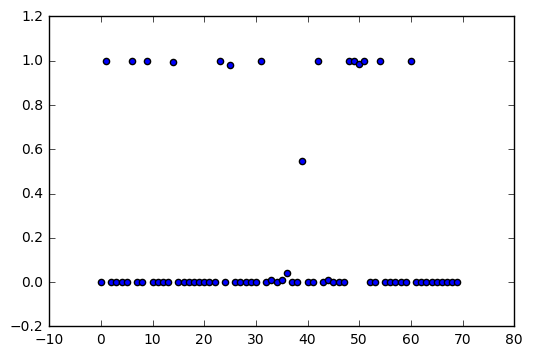

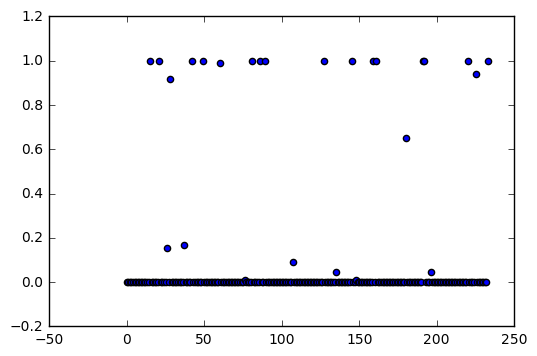

In [6]:
print(confusion_matrix[0])
print(confusion_matrix[1])

plt.scatter(np.arange(0,len(pred_array[0])), pred_array[0])
plt.show()
plt.scatter(np.arange(0,len(pred_array[1])), pred_array[1])
plt.show()

In [7]:
TP = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TN = confusion_matrix[1][1]

AC = (TP+TN) / (TP+FP+TN+FN)
SE = TP / (TP+FN)
SP = TN / (TN+FP)
DI = (2*TP) / (2*TP + FN + FP)

print(AC,SE,SP,DI)

0.756578947368421 0.4411764705882353 0.7962962962962963 0.28846153846153844


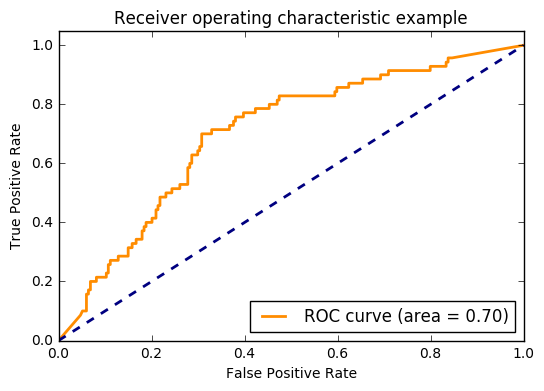

In [8]:
y_true_0 = np.ones(len(pred_array[0]))
y_true_1 = np.zeros(len(pred_array[1]))
y_true = np.concatenate([y_true_0, y_true_1],axis=0)
y_score = np.concatenate(pred_array, axis=0)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()